# Company Bankruptcy Classifer, Nicole Yip

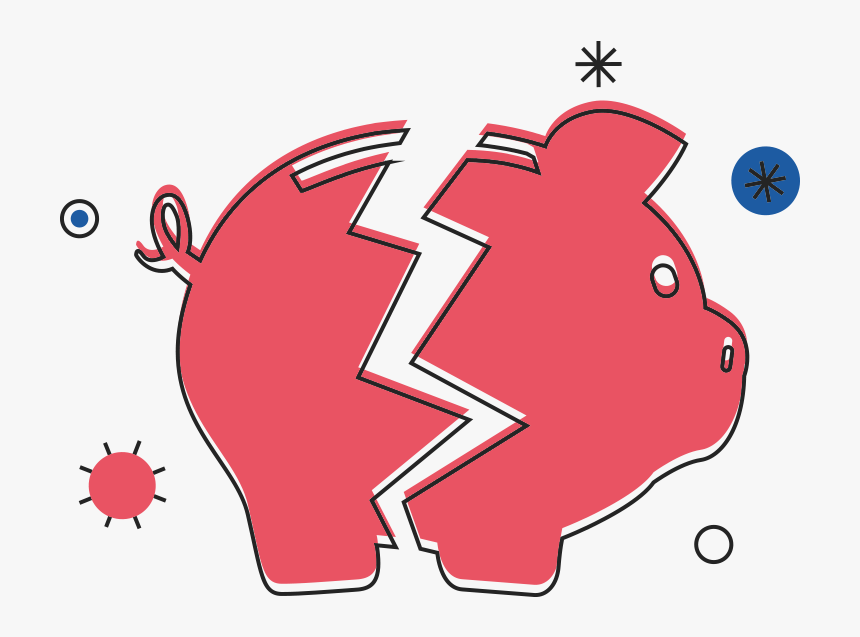
**Goal:** I want to train three classifier machine learning models (Random Forest classifier, logistic regression, SVM) to detect and classify whether a company will go bankrupt or not. The applications of this problem has implications in the realm of credit risk assessment, investment analysis, corporate restructuring, and regulatory compliance. I am using a dataset of Taiwanese companies studied from 1999 to 2009 from the Taiwan Economic Journal.
<br><br>**Task:** I will train three classifiers using pre-labeled training data and apply the classifer on the testing set (which also has labels, as it will be split from the original data set) to see its accuracy. In other words, this will be a supervised learning task of binary classification.

## Import libraries

In [893]:
# Calculation packages
import numpy as np
import pandas as pd

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt 

# Machine learning packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler # use !conda install 

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Exploratory data analysis and data pre-processing

In [750]:
# Read data from csv into a data frame
df = pd.read_csv('./data.csv')

# check data size
df.shape

(6819, 96)

In [751]:
pd.set_option('display.max_columns', None)
df.head(10)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025

In [752]:
df.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

As we can see, we have 96 attributes (including the target variable). This is a large number of features, so we will have to decide how to do feature selection/consider dimensionality reduction later.

In [753]:
# Are there any empty cells? --> No. We will not have to drop/modify them.
df.isnull().sum() # you can expand the whole 96 variables to check.

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [754]:
df.duplicated().sum() # There are no duplicated rows in the df

0

### Exploring the target variable: "Bankrupt?" 

In [755]:
# Let's see how many bankrupt companies there are
bankrupt = df["Bankrupt?"].sum()
non_bankrupt = len(df) - bankrupt
print("Number of bankrupt companies:", bankrupt)
print("Number of non-bankrupt companies:", non_bankrupt)

Number of bankrupt companies: 220
Number of non-bankrupt companies: 6599


Text(0.5, 1.0, 'Target: Bankrupt?')

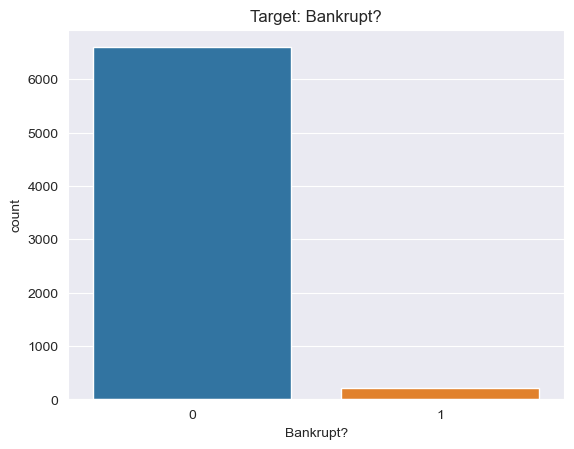

In [756]:
sns.countplot(x=df['Bankrupt?'])
plt.title('Target: Bankrupt?')

As we can see, only ~3.33% of the data set is labeled as bankrupt. This is a highly imbalanced dataset which, if we do not modify, will cause problems with training our models as they will essentially treat "bankrupt" as a minority class and the model will train mostly on "non bankrupt" features, and therefore the model would overfit. We want the model to "learn" how to detect the bankrupt class as well. Ideally, our data should be 50% bankrupt, 50% not bankrupt.
<br><br> *What should we do then?*
Over or down sampling is the way to deal with this. We will address this after looking at the other variables, outliers, and doing some EDA.

### Exploring the feature variables

#### Categorical feature variables

The numeric features of the dataset are "float64" features, while the categorical ones have been encoded as a binary 1/0 and stored as "int64". We will first explore the categorical variables.

In [757]:
# Finding which columns are categorical
numeric_features = df.dtypes[df.dtypes != 'int64'].index
categorical_features = df.dtypes[df.dtypes == 'int64'].index

df[categorical_features].columns.tolist()

['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag']

As we know, "Bankrupt?" is our target variable. Let us explore the two categorical feature variables.

##### Liability-Assets Flag

0    6811
1       8
Name:  Liability-Assets Flag, dtype: int64


<AxesSubplot:xlabel=' Liability-Assets Flag', ylabel='count'>

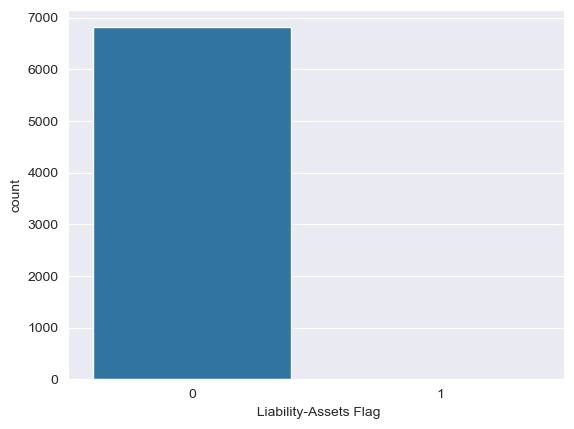

In [758]:
# Liability-Assets Flag
# careful, realized that the dataset columns have space before the name
print(df[' Liability-Assets Flag'].value_counts())
sns.countplot(' Liability-Assets Flag',data=df)

The meaning of this variable is whether the total libaility of the company exceeds total assets. If this is true, the flag will be positive, "1". Most of the time (besides 8 instances), this is not true. Let's see what our instances of bankruptcy are like for this particular variable.

 Liability-Assets Flag  Bankrupt?
0                       0            6597
                        1             214
1                       1               6
                        0               2
dtype: int64


<AxesSubplot:xlabel=' Liability-Assets Flag', ylabel='count'>

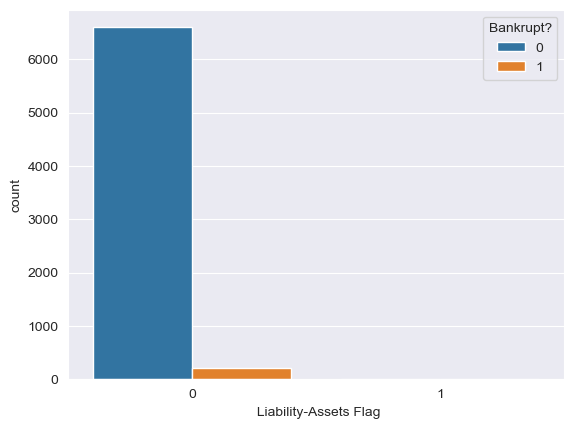

In [759]:
print(df[[' Liability-Assets Flag','Bankrupt?']].value_counts())
sns.countplot(x = ' Liability-Assets Flag',hue = 'Bankrupt?',data = df)

We can see that in most cases, the flag is not raised (0), and in those cases, the majority of bankrupt companies (214) will not raise the flag. However, in the 8 times the flag is raised, 6 times it is a bankrupt company and 2 times it is not. I would say that this is a useful variable, but certainly not strongly indicative of bankruptcy.

##### Net Income Flag

1    6819
Name:  Net Income Flag, dtype: int64


<AxesSubplot:xlabel=' Net Income Flag', ylabel='count'>

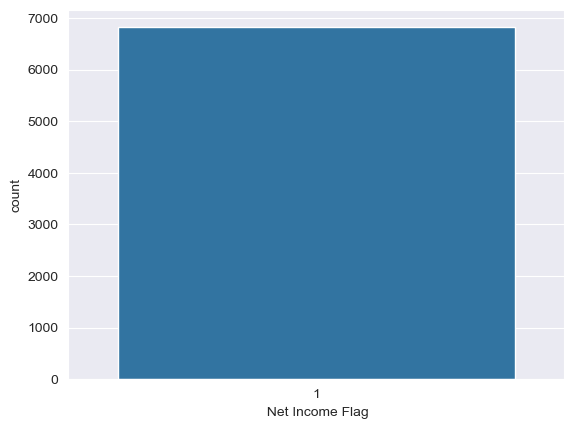

In [760]:
print(df[' Net Income Flag'].value_counts())
sns.countplot(' Net Income Flag',data=df)

Net Income variable indicates whether the company's net income is negative for the past two years, which if true, will raise the flag. Every company in the dataset has been experiencing loss in the past two years. 

Let's do some interpretation: is this therefore going to be a useful variable for our data? No. Broadly speaking, there is no variation in whether it determines bankruptcy or not since every single instance raises the flag. But diving deeper, we can infer that companies that did not go bankrupt managed to stabilize their businesses despite posting net losses. 

**Action:** drop this feature from the df. We already have a large number of features, let's cut it down where suitable. We don't want our models to be trained on unnecessary features, as it may lead to overfitting.

In [761]:
df = df.drop(' Net Income Flag', axis=1)

#### Numerical feature variables -- outliers

Let's look at the boxplots of all the columns in the df to get an overview of what outliers look like. The most efficient way to view it is to put it all in one graph so that we can evaluate which outliers to look deeper into as there are now 94 features. 

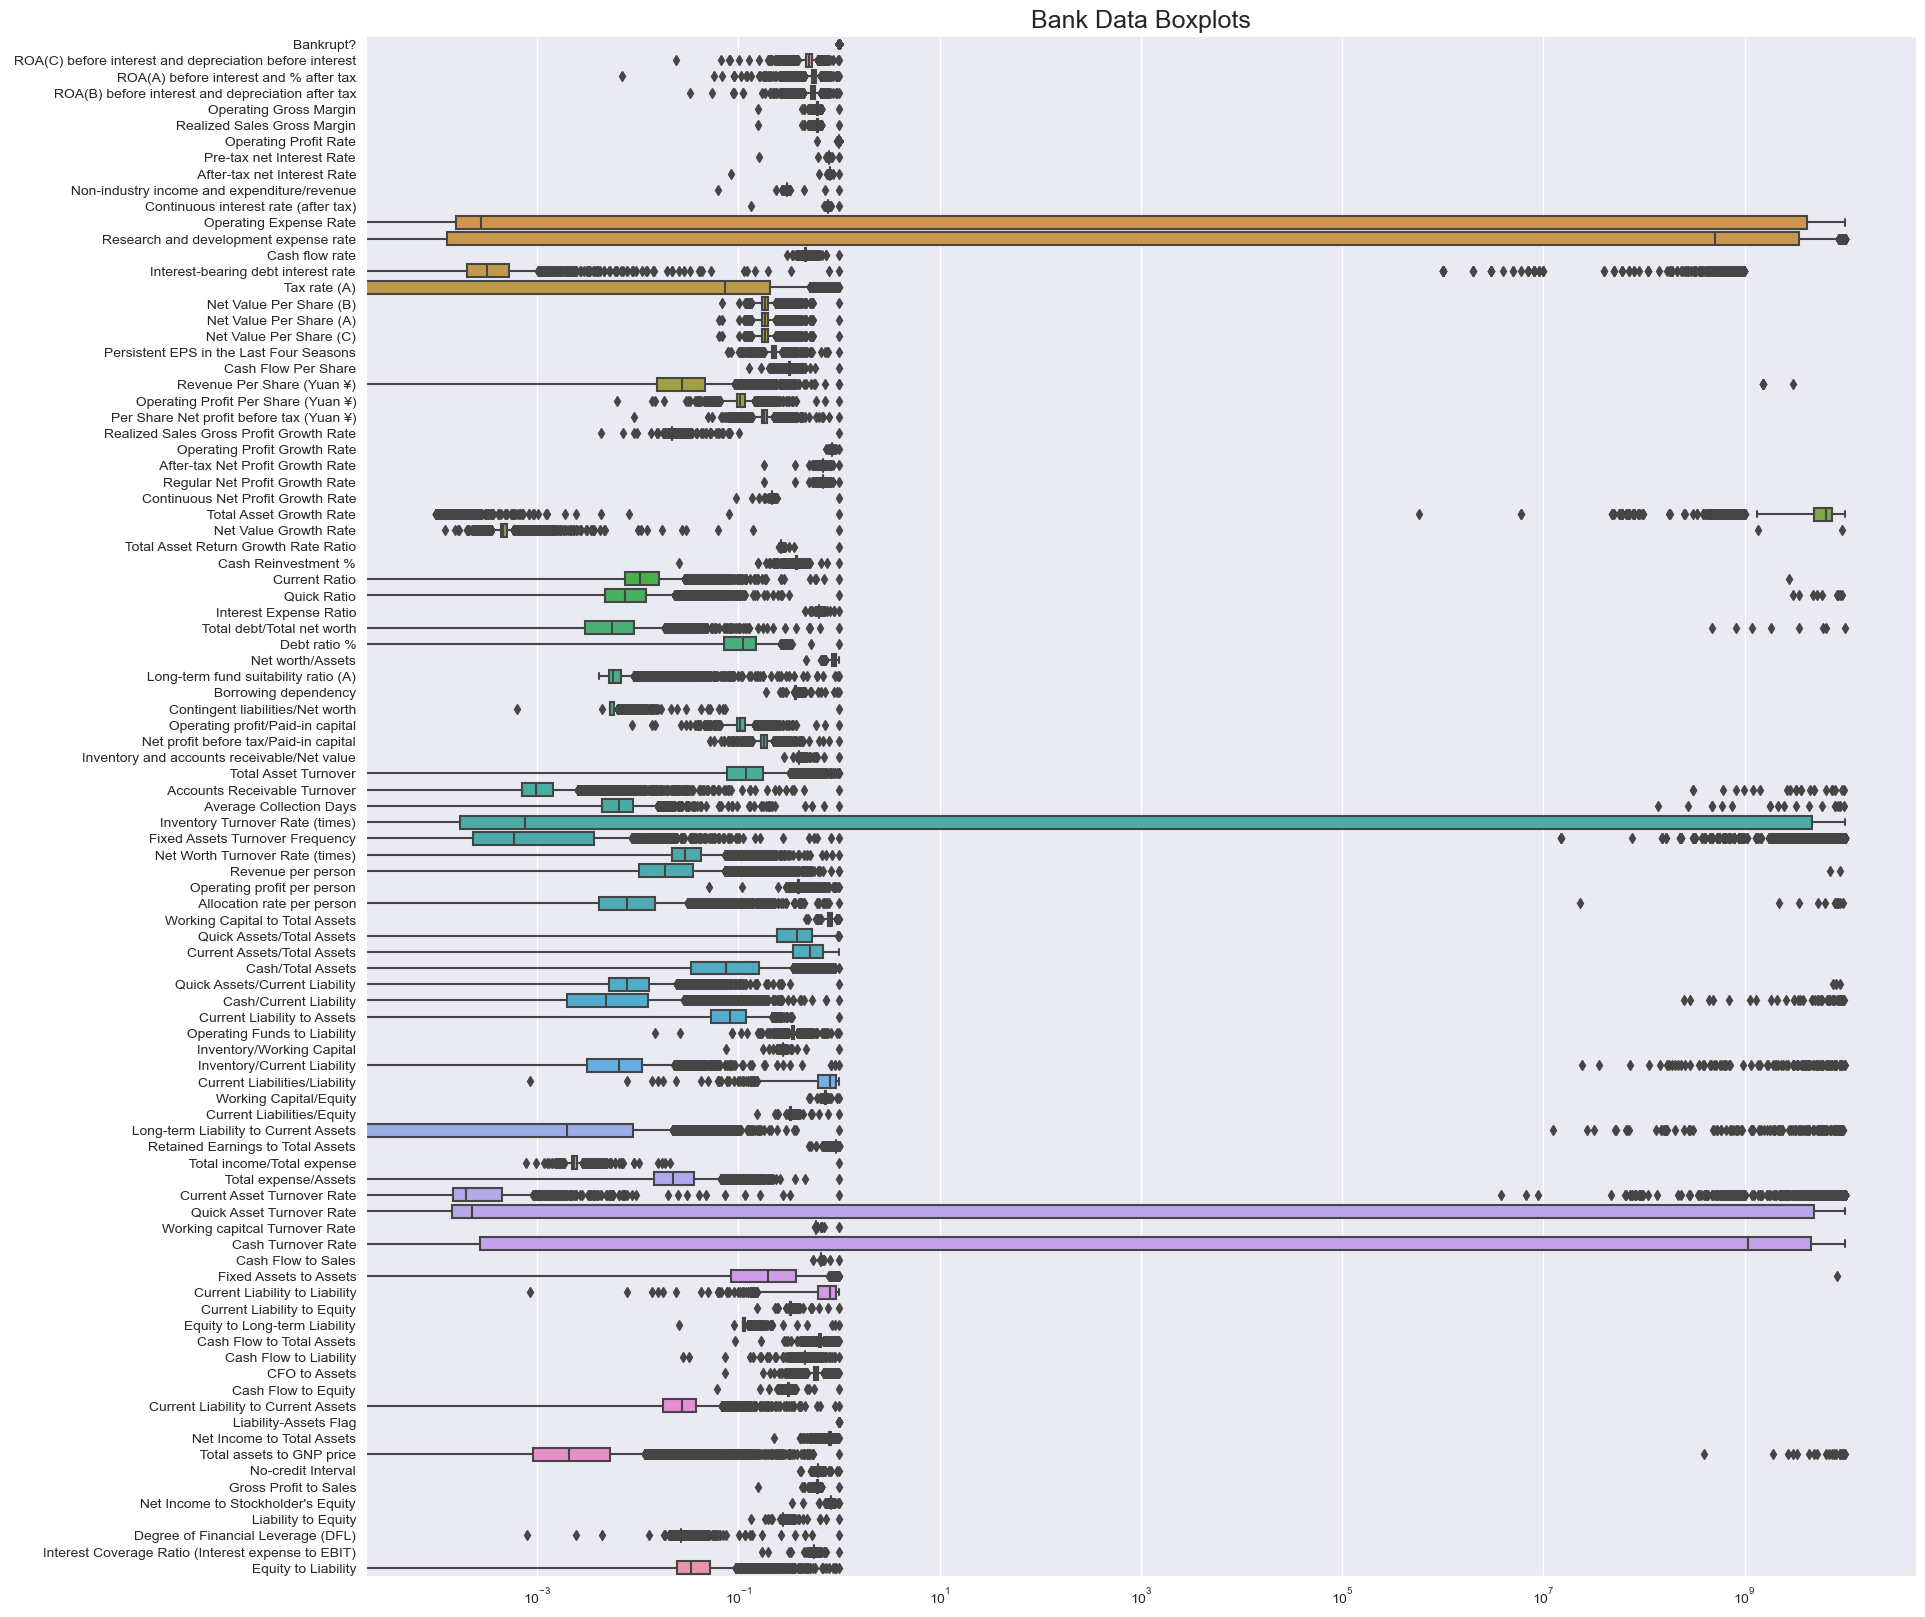

In [762]:
plt.figure(figsize = (20,20))
ax = sns.boxplot(data = df, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

Remember, we do not want to remove too many outliers, especially those that can represent natural variation. Moreover, we should be aware that our dataset is already incredibly imbalanced. We do not want to run into the issue that we remove so many outliers that we further imbalance our data. Therefore, I will make the decision to only remove *extreme* outliers because of this issue of imbalance.

What should we determine as "extreme" outliers, besides the standard IQR min/max? I will visually flag what seems like extreme outliers from the boxplots above, and then explore those variables more closely. If it confirms that those are extreme outliers, I will then remove them. This is an imperfect process that is pretty subjective, but it is my best solution so far to make sure I don't accidentally downsize our minority class even more.

In this case, we'll define "outliers" for this dataset to be less about the spread of each variable, but rather to do with whether there are clusters/points that are far from the main cluster. For example, "Revenue Per Share (Yuan) has a very large spread and many outliers in its main IQR plot area, but also has another two visible clusters far to the right of this plot. I would count those further clusters as outliers, and not necessarily the group of outliers next to the box plot itself.

In another example, like "Cash flow rate", we can see that there are clusters of outliers far away from the box plot itself. However, it is such a large cluster spread of outliers that those will not be removed. I will evaluate each boxplot on a case by case basis.

I am noticing that these following variables have extreme outliers as outlined above:
1. Revenue Per Share (Yuan ¥)
2. Realized Sales Gross Profit Growth Rate
3. Total Asset Growth Rate
4. Current Ratio
5. Contingent liabilities/Net worth
6. Revenue per person
7. Total income/Total expense
8. Fixed Assets to Assets
9. Current Liability to Liability

These variables also are worth exploring as they have extreme outliers upon further review. But I will check the above group first, re-evaluate to see how many of the minority group we have removed before proceeding to check this group.

10. Operating Gross Margin
11. Realized Sales Gross Margin
12. Operating Profit Rate
13. Pre-tax net Interest Rate
14. After-tax net Interest Rate
15. Continuous interest rate (after tax)
16. Total Asset Return Growth Rate Ratio
17. Cash Reinvestment %
18. Quick Assets/Current Liability
19. Current Liabilities/Liability
20. Working capital Turnover Rate
21. Net Income to Total Assets

Let's explore each variable individually and remove the outliers.

###### Revenue Per Share (Yuan ¥)

<AxesSubplot:xlabel=' Revenue Per Share (Yuan ¥)'>

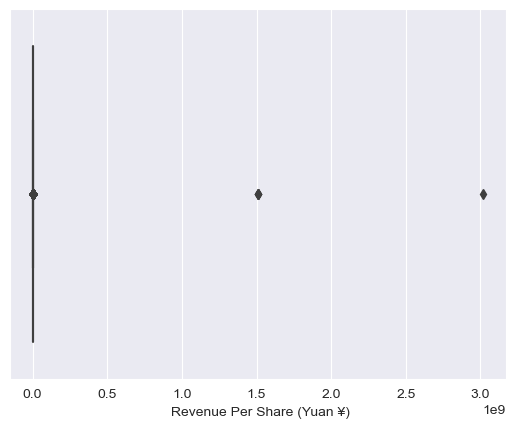

In [763]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Revenue Per Share (Yuan ¥)'], orient='h')

In [764]:
# We can see that the outliers are above 1.5 Yuan Revenue Per Share
# Let's see how many there are
len(df[df[' Revenue Per Share (Yuan ¥)'] > 1.5])

5

In [765]:
# 5 seems like an appropriate number of outliers we can remove.
print(f"Shape before: {df.shape}")
df.drop(df[df[' Revenue Per Share (Yuan ¥)'] > 1.5].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6819, 95)
Shape after:  (6814, 95)


<AxesSubplot:xlabel=' Revenue Per Share (Yuan ¥)'>

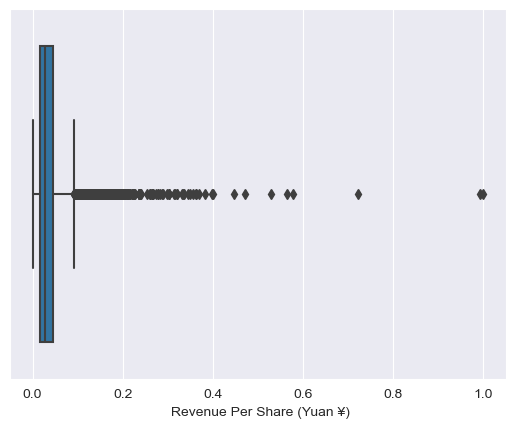

In [766]:
# That wasn't many, so let's draw another box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Revenue Per Share (Yuan ¥)'], orient='h')

We now have a clearer picture of the outliers as the box plot is scaled better. Let's also remove the outliers above 0.5 as they are quite far from the main box plot.

In [767]:
len(df[df[' Revenue Per Share (Yuan ¥)'] > 0.5])

6

In [768]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Revenue Per Share (Yuan ¥)'] > 0.5].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6814, 95)
Shape after:  (6808, 95)


##### Realized Sales Gross Profit Growth Rate

<AxesSubplot:xlabel=' Realized Sales Gross Profit Growth Rate'>

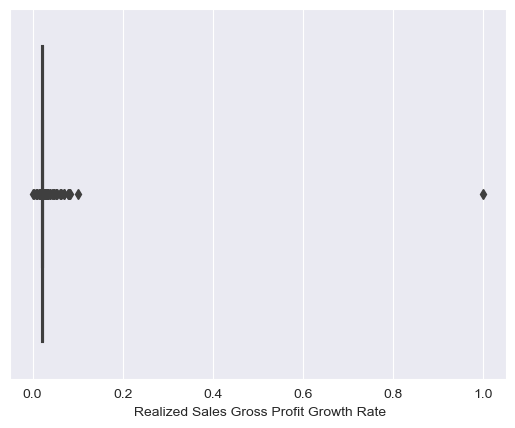

In [769]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Realized Sales Gross Profit Growth Rate'], orient='h')

In [770]:
# We can see that the outliers are above 0.8
# Let's see how many there are
len(df[df[' Realized Sales Gross Profit Growth Rate'] > 0.8])

1

In [771]:
# 1 seems like an appropriate number of outliers we can remove.
print(f"Shape before: {df.shape}")
df.drop(df[df[' Realized Sales Gross Profit Growth Rate'] > 0.8].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6808, 95)
Shape after:  (6807, 95)


<AxesSubplot:xlabel=' Realized Sales Gross Profit Growth Rate'>

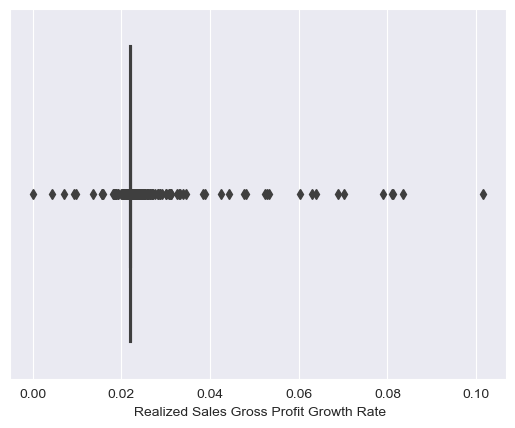

In [772]:
# Let's draw another box plot to see if there are other outliers

sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Realized Sales Gross Profit Growth Rate'], orient='h')

In [773]:
# Let's also remove those above 0.07
len(df[df[' Realized Sales Gross Profit Growth Rate'] > 0.07])

6

In [774]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Realized Sales Gross Profit Growth Rate'] > 0.07].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6807, 95)
Shape after:  (6801, 95)


##### Total Asset Growth Rate

<AxesSubplot:xlabel=' Total Asset Growth Rate'>

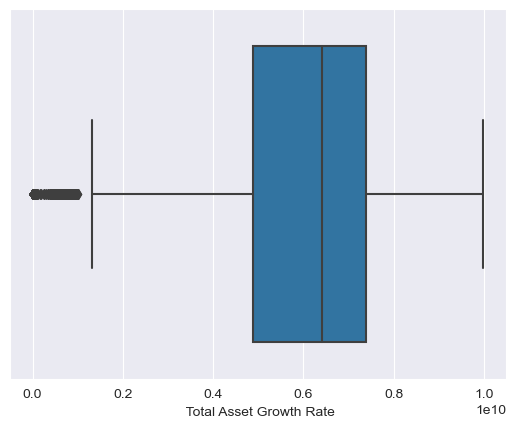

In [775]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Total Asset Growth Rate'], orient='h')

It seems like most of the outliers are below the IQR min. Let's find out what that is.

In [776]:
# helper function to determine outliers through IQR
def summarize_quartiles(df, col):
    Q1 = np.quantile(df[col], 0.25)
    Q3 = np.quantile(df[col], 0.75)
    IQR = Q3 - Q1
    lower_thresh = Q1 - 1.5 * IQR
    upper_thresh = Q3 + 1.5 * IQR
    print("Q1:", Q1, "Q3:", Q3, "min:", lower_thresh, "max:", upper_thresh)
    print("Number of outliers under min_thresh:", len(df[df[col] < lower_thresh]))
    print("Number of outliers above max_thresh:", len(df[df[col] > upper_thresh]))
    return lower_thresh, upper_thresh

In [777]:
summarize_quartiles(df, ' Total Asset Growth Rate')

Q1: 4880000000.0 Q3: 7390000000.0 min: 1115000000.0 max: 11155000000.0
Number of outliers under min_thresh: 1371
Number of outliers above max_thresh: 0


(1115000000.0, 11155000000.0)

There are too many outliers to remove (1371). Recall that our minority class only has around 220 instances. There is also not a clear divide between outliers and extreme outliers in this cluster, so I will not remove them.

##### Current Ratio

<AxesSubplot:xlabel=' Current Ratio'>

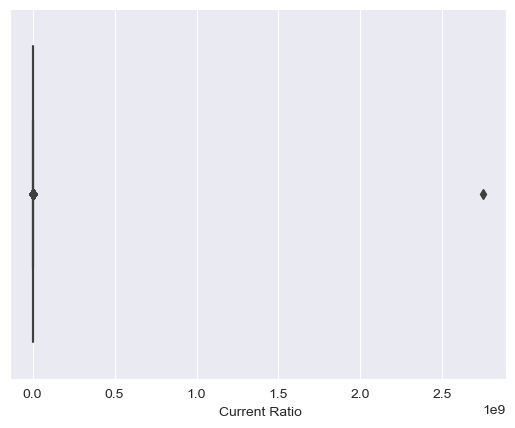

In [778]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Current Ratio'], orient='h')

In [779]:
# We can see that the outliers are above 2.5
# Let's see how many there are
len(df[df[' Current Ratio'] > 2.5])

1

In [780]:
# Let's remove that 1 outlier and recheck the box plot as before.
print(f"Shape before: {df.shape}")
df.drop(df[df[' Current Ratio'] > 2.5].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6801, 95)
Shape after:  (6800, 95)


<AxesSubplot:xlabel=' Current Ratio'>

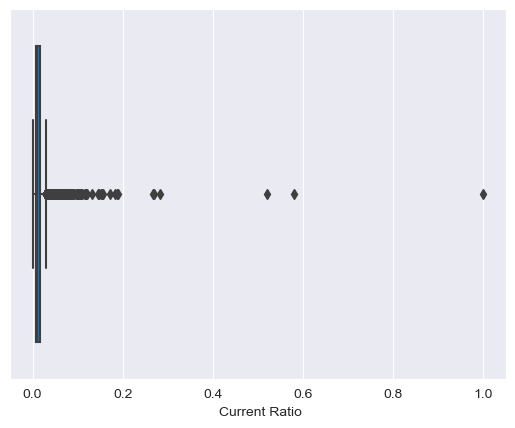

In [781]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Current Ratio'], orient='h')

In [782]:
# We can see that the outliers are above 0.2
# Let's see how many there are and then remove them.
len(df[df[' Current Ratio'] > 0.2])

6

In [783]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Current Ratio'] > 0.2].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6800, 95)
Shape after:  (6794, 95)


##### Contingent liabilities/Net worth

<AxesSubplot:xlabel=' Contingent liabilities/Net worth'>

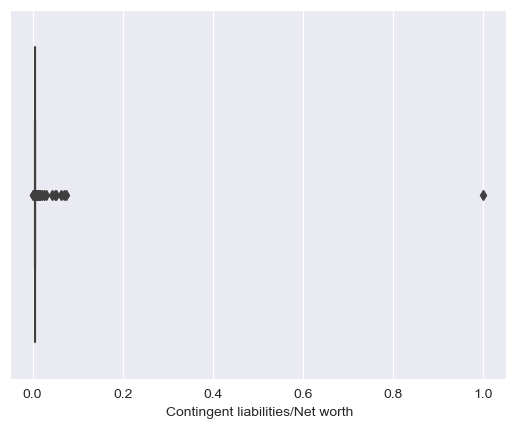

In [784]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Contingent liabilities/Net worth'], orient='h')

In [785]:
# We can see that the outliers are above 0.8
# Let's see how many there are and then remove them.
len(df[df[' Contingent liabilities/Net worth'] > 0.8])

1

In [786]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Contingent liabilities/Net worth'] > 0.8].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6794, 95)
Shape after:  (6793, 95)


<AxesSubplot:xlabel=' Contingent liabilities/Net worth'>

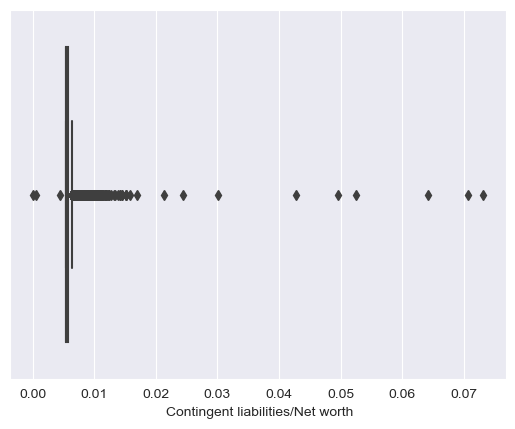

In [787]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Contingent liabilities/Net worth'], orient='h')

In [788]:
# We can see that the outliers are above 0.03
# Let's see how many there are and then remove them.
len(df[df[' Contingent liabilities/Net worth'] > 0.03])

7

In [789]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Contingent liabilities/Net worth'] > 0.03].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6793, 95)
Shape after:  (6786, 95)


##### Revenue per person

<AxesSubplot:xlabel=' Revenue per person'>

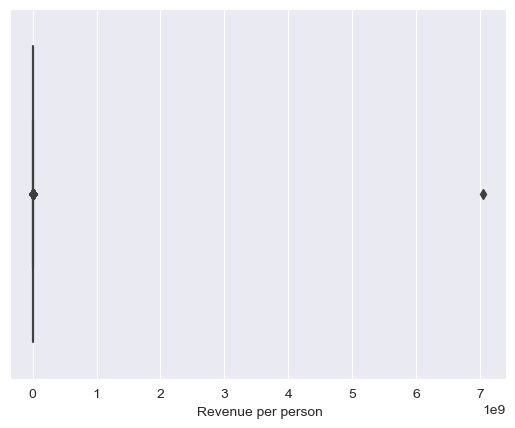

In [790]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Revenue per person'], orient='h')

In [791]:
# We can see that the outliers are above 7
# Let's see how many there are and then remove them.
len(df[df[' Revenue per person'] > 7])

1

In [792]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Revenue per person'] > 7].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6786, 95)
Shape after:  (6785, 95)


<AxesSubplot:xlabel=' Revenue per person'>

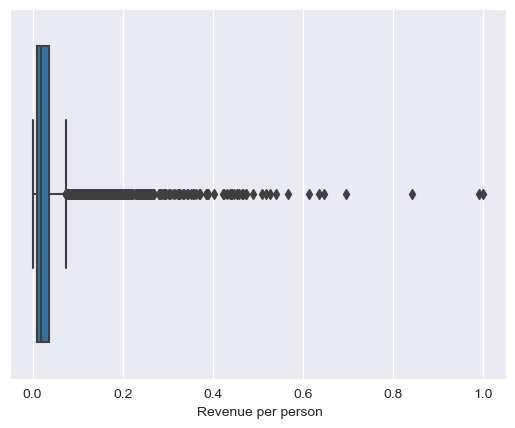

In [793]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Revenue per person'], orient='h')

In [794]:
# We can see that the outliers are above 0.6
# Let's see how many there are and then remove them.
len(df[df[' Revenue per person'] > 0.6])

7

In [795]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Revenue per person'] > 0.6].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6785, 95)
Shape after:  (6778, 95)


##### Total income/Total expense

<AxesSubplot:xlabel=' Total income/Total expense'>

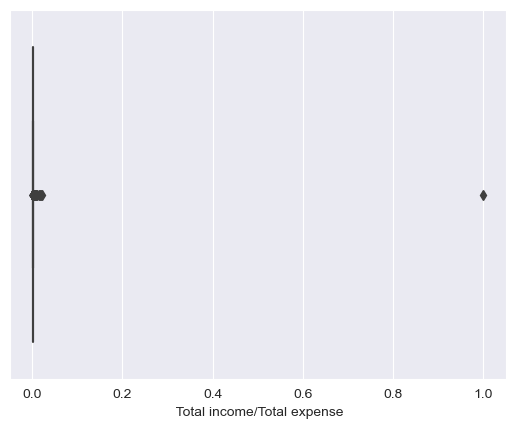

In [796]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Total income/Total expense'], orient='h')

In [797]:
# We can see that the outliers are above 0.8
# Let's see how many there are and then remove them.
len(df[df[' Total income/Total expense'] > 0.8])

1

In [798]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Total income/Total expense'] > 0.8].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6778, 95)
Shape after:  (6777, 95)


<AxesSubplot:xlabel=' Total income/Total expense'>

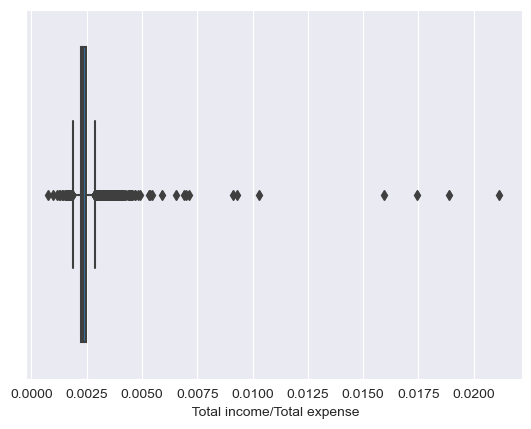

In [799]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Total income/Total expense'], orient='h')

In [800]:
# We can see that the outliers are above 0.0075
# Let's see how many there are and then remove them.
len(df[df[' Total income/Total expense'] > 0.0075])

7

In [801]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Total income/Total expense'] > 0.0075].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6777, 95)
Shape after:  (6770, 95)


##### Fixed Assets to Assets

<AxesSubplot:xlabel=' Fixed Assets to Assets'>

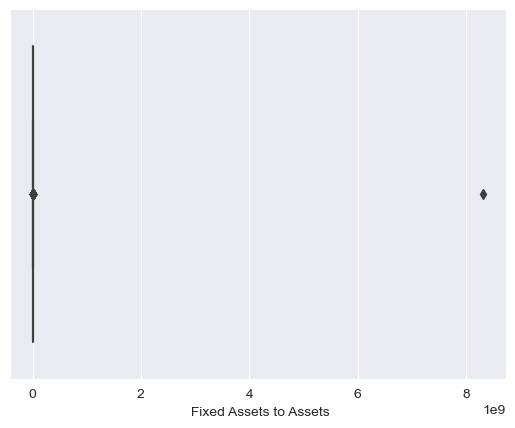

In [802]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Fixed Assets to Assets'], orient='h')

In [803]:
# We can see that the outliers are above 6
# Let's see how many there are and then remove them.
len(df[df[' Fixed Assets to Assets'] > 6])

1

In [804]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Fixed Assets to Assets'] > 6].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6770, 95)
Shape after:  (6769, 95)


<AxesSubplot:xlabel=' Fixed Assets to Assets'>

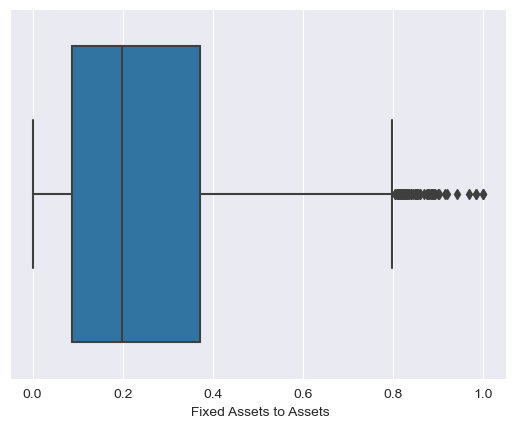

In [805]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Fixed Assets to Assets'], orient='h')

As stated above, we have decided that for this imbalanced dataset, we will only remove outliers that are extremely far from the original box plots. So, we will leave this alone after clearing the one instace that had "Fixed Assets to Assets" > 6

##### Current Liability to Liability

<AxesSubplot:xlabel=' Current Liability to Liability'>

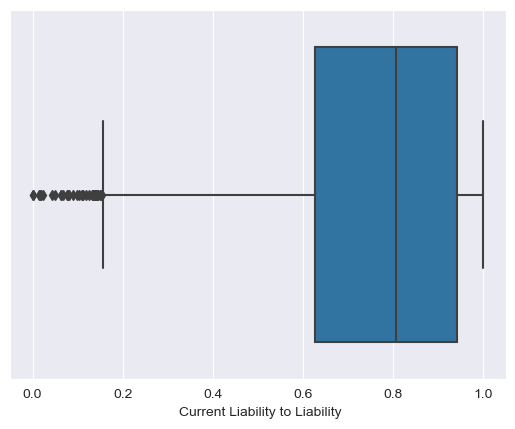

In [806]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Current Liability to Liability'], orient='h')

Most of the outliers are below the IQR min. Let's see what they are before trying to remove them. Perhaps there aren't extreme outliers for this variable after the previous cleaning for the other variables.

In [807]:
summarize_quartiles(df, ' Current Liability to Liability')

Q1: 0.627209697491948 Q3: 0.94148530926374 min: 0.15579627983426003 max: 1.412898726921428
Number of outliers under min_thresh: 37
Number of outliers above max_thresh: 0


(0.15579627983426003, 1.412898726921428)

There are too many outliers to remove (37). Recall that our minority class only has around 220 instances. There is also not a clear divide between outliers and extreme outliers in this cluster, so I will not remove them.

##### Outliers, cont.

In [808]:
# How many total outliers did we remove? We began with 6819 instances.
df.shape

(6769, 95)

In [809]:
# We removed 50 outliers. But let's see how our minority class has been impacted
bankrupt = df["Bankrupt?"].sum()
non_bankrupt = len(df) - bankrupt
print("Number of bankrupt companies:", bankrupt)
print("Number of non-bankrupt companies:", non_bankrupt)

Number of bankrupt companies: 215
Number of non-bankrupt companies: 6554


Originally, we had 220 bankrupt companies. In removing 50 outliers, we only removed 5 (2.27%) from this already small minority class. I believe that this is somewhat sucessful in our mission to try to identify extreme outliers without impacting our minority class.

Lets move on to group 2 of our outlier removals.

##### Operating Gross Margin

<AxesSubplot:xlabel=' Operating Gross Margin'>

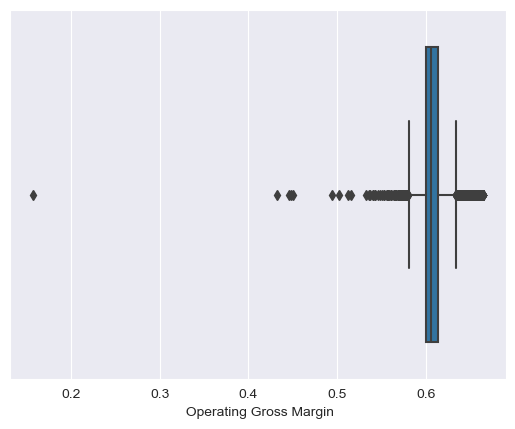

In [810]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Operating Gross Margin'], orient='h')

In [811]:
# We can see that the outliers are below 0.45
# Let's see how many there are and then remove them.
len(df[df[' Operating Gross Margin'] < 0.45])

5

In [812]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Operating Gross Margin'] < 0.45].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6769, 95)
Shape after:  (6764, 95)


**Since the outlier box plot did not have an unreadable scale to begin with, we will not check this variable twice like we would with the variables with unreadable plots the first time.**

##### Realized Sales Gross Margin

<AxesSubplot:xlabel=' Realized Sales Gross Margin'>

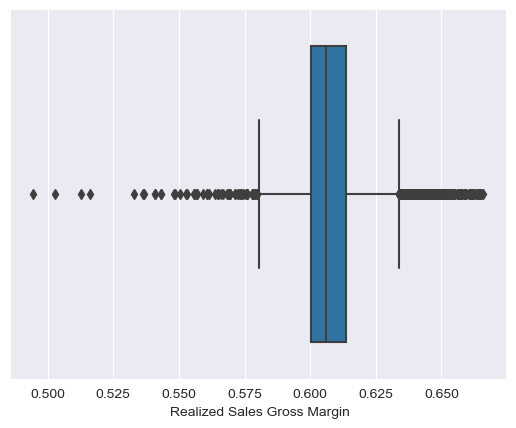

In [813]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Realized Sales Gross Margin'], orient='h')

In [814]:
# We can see that the outliers are below 0.525
# Let's see how many there are and then remove them.
len(df[df[' Realized Sales Gross Margin'] < 0.525])

4

In [815]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Realized Sales Gross Margin'] < 0.525].index, inplace=True)
print(f"Shape after:  {df.shape}")
# And again, since the plot was at a readable scale, we will proceed to the next variable.

Shape before: (6764, 95)
Shape after:  (6760, 95)


##### Operating Profit Rate

<AxesSubplot:xlabel=' Operating Profit Rate'>

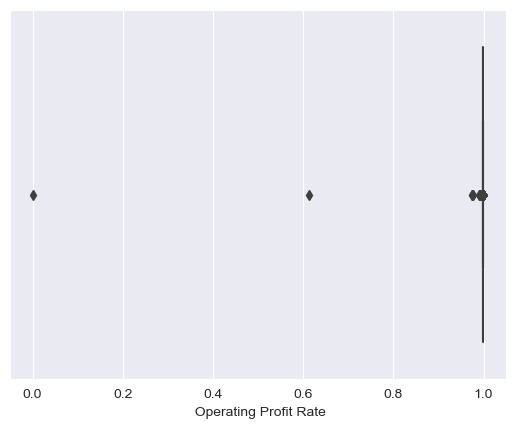

In [816]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Operating Profit Rate'], orient='h')

In [817]:
# We can see that the outliers are below 0.8
# Let's see how many there are and then remove them.
len(df[df[' Operating Profit Rate'] < 0.8])

2

In [818]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Operating Profit Rate'] < 0.8].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6760, 95)
Shape after:  (6758, 95)


<AxesSubplot:xlabel=' Operating Profit Rate'>

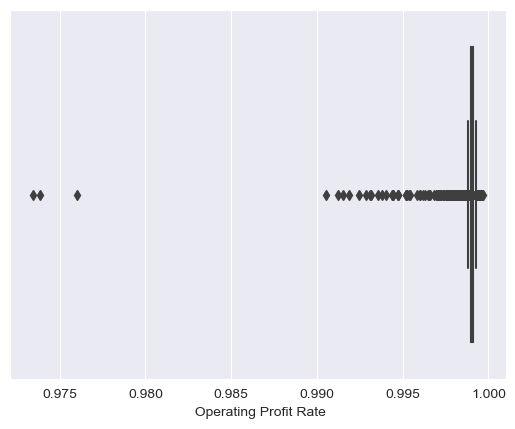

In [819]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Operating Profit Rate'], orient='h')

In [820]:
# We can see that the outliers are below 0.980
# Let's see how many there are and then remove them.
len(df[df[' Operating Profit Rate'] < 0.980])

3

In [821]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Operating Profit Rate'] < 0.980].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6758, 95)
Shape after:  (6755, 95)


##### Pre-tax net Interest Rate

<AxesSubplot:xlabel=' Pre-tax net Interest Rate'>

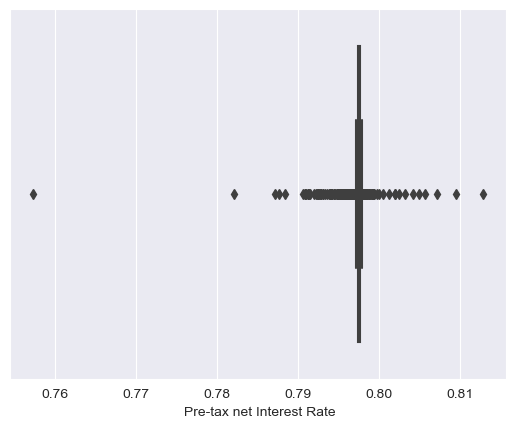

In [822]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Pre-tax net Interest Rate'], orient='h')

In [823]:
# We can see that the outliers are above 0.81 and below 0.78
# Let's see how many there are and then remove them.
print(len(df[df[' Pre-tax net Interest Rate'] < 0.78]),len(df[df[' Pre-tax net Interest Rate'] > 0.81]))

1 1


In [824]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Pre-tax net Interest Rate'] < 0.78].index, inplace=True)
df.drop(df[df[' Pre-tax net Interest Rate'] > 0.81].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6755, 95)
Shape after:  (6753, 95)


<AxesSubplot:xlabel=' Pre-tax net Interest Rate'>

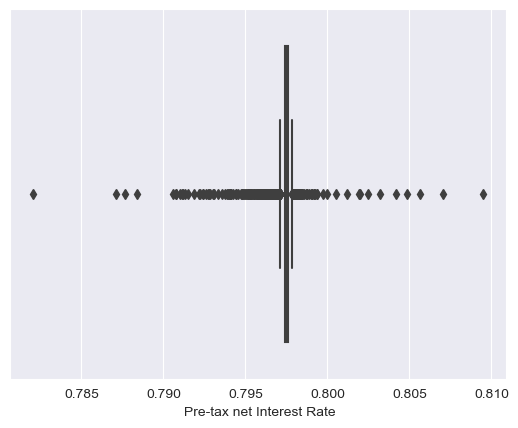

In [825]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Pre-tax net Interest Rate'], orient='h')

In [826]:
len(df[df[' Pre-tax net Interest Rate'] < 0.785])
# if I do <0.795, there are 40+ outliers. That is too many to remove.

1

In [827]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Pre-tax net Interest Rate'] < 0.785].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6753, 95)
Shape after:  (6752, 95)


##### After-tax net Interest Rate

<AxesSubplot:xlabel=' After-tax net Interest Rate'>

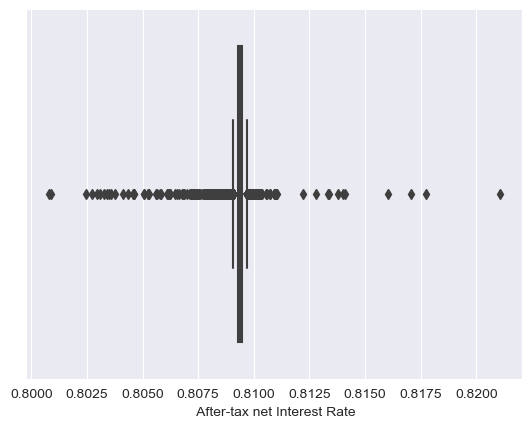

In [828]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' After-tax net Interest Rate'], orient='h')

In [829]:
# We can see that the outliers are above 0.8200 and below 0.8025
# Let's see how many there are and then remove them.
print(len(df[df[' After-tax net Interest Rate'] < 0.8025]),len(df[df[' After-tax net Interest Rate'] > 0.8200]))

3 1


In [830]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' After-tax net Interest Rate'] < 0.8025].index, inplace=True)
df.drop(df[df[' After-tax net Interest Rate'] > 0.8200].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6752, 95)
Shape after:  (6748, 95)


##### Continuous interest rate (after tax)

<AxesSubplot:xlabel=' Continuous interest rate (after tax)'>

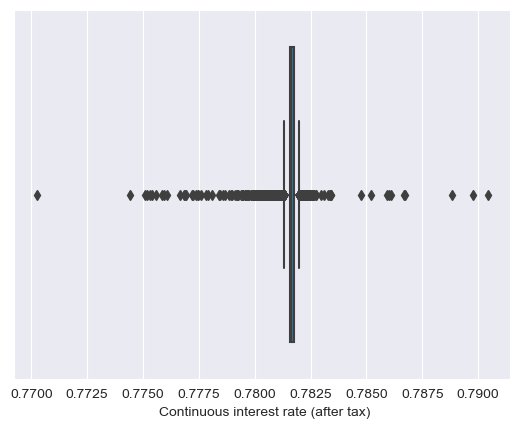

In [831]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Continuous interest rate (after tax)'], orient='h')

In [832]:
# We can see that the outliers are above 0.7875 and below 0.7750
# Let's see how many there are and then remove them.
print(len(df[df[' Continuous interest rate (after tax)'] < 0.7750]),len(df[df[' Continuous interest rate (after tax)'] > 0.7875]))

2 3


In [833]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Continuous interest rate (after tax)'] < 0.7750].index, inplace=True)
df.drop(df[df[' Continuous interest rate (after tax)'] > 0.7875].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6748, 95)
Shape after:  (6743, 95)


<AxesSubplot:xlabel=' Continuous interest rate (after tax)'>

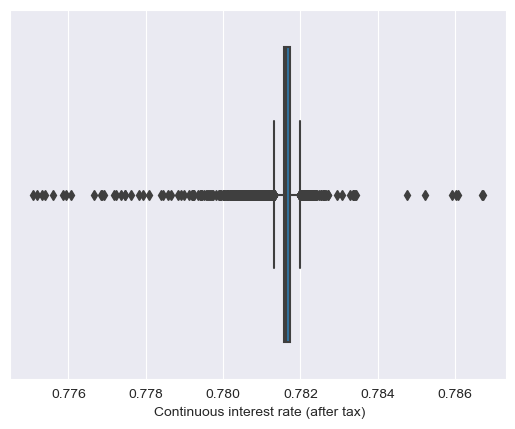

In [834]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Continuous interest rate (after tax)'], orient='h')

In [835]:
# The right side still has more "extreme" outliers above 0.786
len(df[df[' Continuous interest rate (after tax)'] > 0.786])

4

In [836]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Continuous interest rate (after tax)'] > 0.786].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6743, 95)
Shape after:  (6739, 95)


##### Total Asset Return Growth Rate Ratio

<AxesSubplot:xlabel=' Total Asset Return Growth Rate Ratio'>

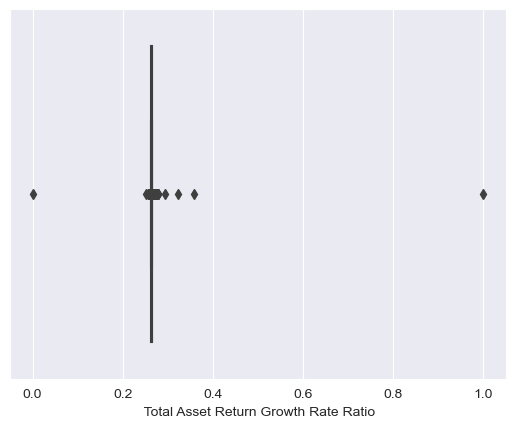

In [837]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Total Asset Return Growth Rate Ratio'], orient='h')

In [838]:
# We can see that the outliers are above 0.8 and below 0.2
# Let's see how many there are and then remove them.
print(len(df[df[' Total Asset Return Growth Rate Ratio'] < 0.2]),len(df[df[' Total Asset Return Growth Rate Ratio'] > 0.8]))

1 1


In [839]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Total Asset Return Growth Rate Ratio'] < 0.2].index, inplace=True)
df.drop(df[df[' Total Asset Return Growth Rate Ratio'] > 0.8].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6739, 95)
Shape after:  (6737, 95)


<AxesSubplot:xlabel=' Total Asset Return Growth Rate Ratio'>

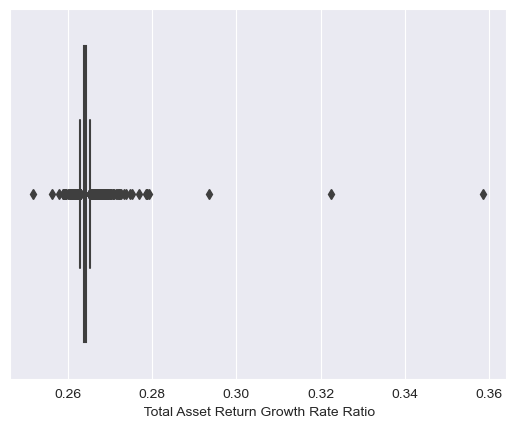

In [840]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Total Asset Return Growth Rate Ratio'], orient='h')

In [841]:
len(df[df[' Total Asset Return Growth Rate Ratio'] > 0.28])

3

In [842]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Total Asset Return Growth Rate Ratio'] > 0.28].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6737, 95)
Shape after:  (6734, 95)


<AxesSubplot:xlabel=' Total Asset Return Growth Rate Ratio'>

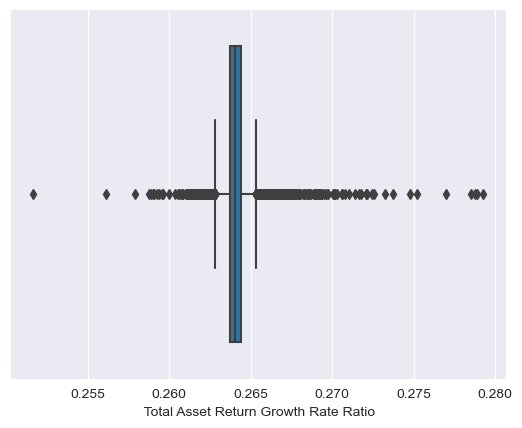

In [843]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Total Asset Return Growth Rate Ratio'], orient='h')

In [844]:
len(df[df[' Total Asset Return Growth Rate Ratio'] < 0.255])

1

In [845]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Total Asset Return Growth Rate Ratio'] < 0.255].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6734, 95)
Shape after:  (6733, 95)


##### Cash Reinvestment %

<AxesSubplot:xlabel=' Cash Reinvestment %'>

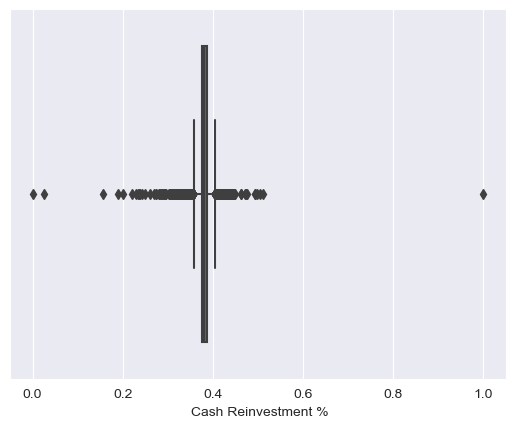

In [846]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Cash Reinvestment %'], orient='h')

In [847]:
# We can see that the outliers are above 0.8 and below 0.1
# Let's see how many there are and then remove them.
print(len(df[df[' Cash Reinvestment %'] < 0.1]),len(df[df[' Cash Reinvestment %'] > 0.8]))

2 1


In [848]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Cash Reinvestment %'] < 0.1].index, inplace=True)
df.drop(df[df[' Cash Reinvestment %'] > 0.8].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6733, 95)
Shape after:  (6730, 95)


##### Quick Assets/Current Liability

<AxesSubplot:xlabel=' Quick Assets/Current Liability'>

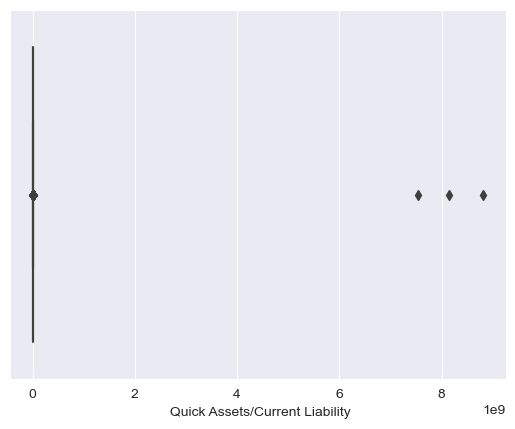

In [849]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Quick Assets/Current Liability'], orient='h')

In [850]:
# We can see the outliers above 6. Let's see how many there are
len(df[df[' Quick Assets/Current Liability'] > 6])

3

In [851]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Quick Assets/Current Liability'] > 6].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6730, 95)
Shape after:  (6727, 95)


<AxesSubplot:xlabel=' Quick Assets/Current Liability'>

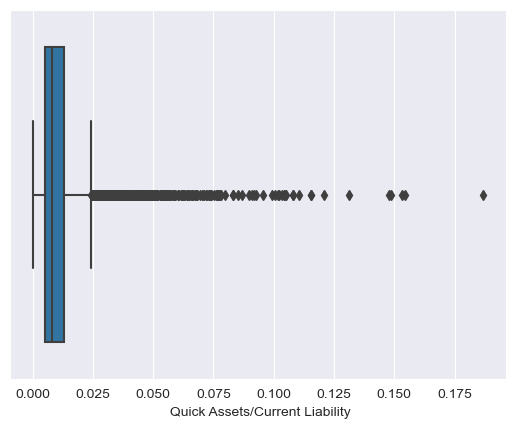

In [852]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Quick Assets/Current Liability'], orient='h')

In [853]:
# The only outlier left that isn't part of a cluster is > 0.175
len(df[df[' Quick Assets/Current Liability'] > 0.175])

1

In [854]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Quick Assets/Current Liability'] > 0.175].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6727, 95)
Shape after:  (6726, 95)


##### Current Liabilities/Liability

<AxesSubplot:xlabel=' Current Liabilities/Liability'>

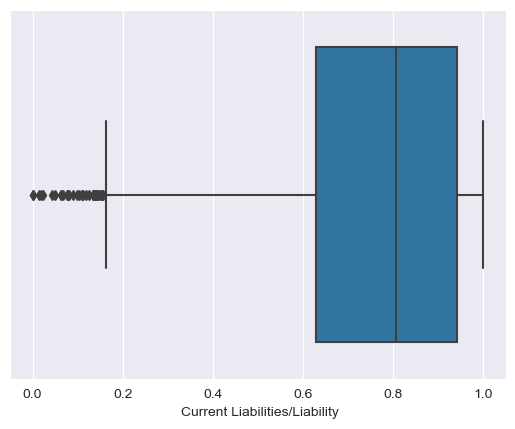

In [855]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Current Liabilities/Liability'], orient='h')

As mentioned in our standard before, these outliers are too clustered for us to consider them "extreme". So we will not remove them.

##### Working capital Turnover Rate

<AxesSubplot:xlabel=' Working capitcal Turnover Rate'>

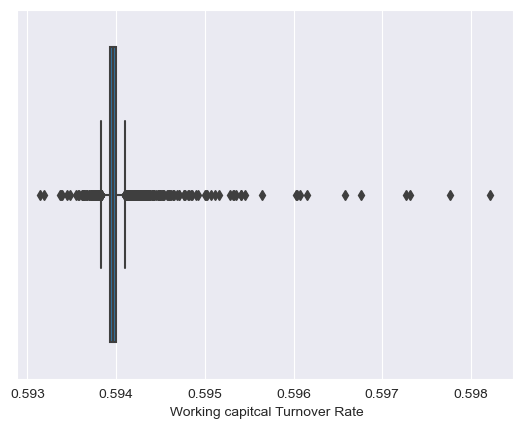

In [856]:
# draw box plot to check outliers
# NOTE that this variable has a spelling error in the original data
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Working capitcal Turnover Rate'], orient='h')

In [857]:
# Let's check the outliers > 0.597
len(df[df[' Working capitcal Turnover Rate'] > 0.597])

4

In [858]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Working capitcal Turnover Rate'] > 0.597].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6726, 95)
Shape after:  (6722, 95)


##### Net Income to Total Assets

<AxesSubplot:xlabel=' Net Income to Total Assets'>

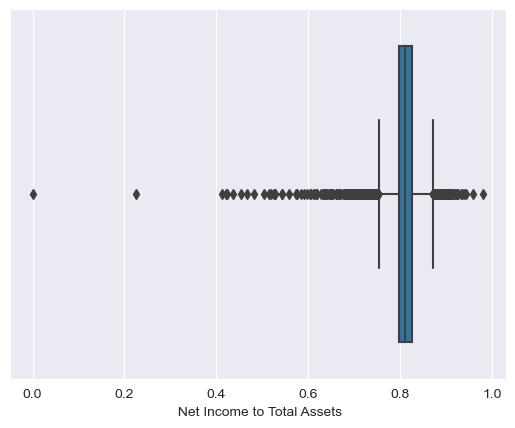

In [859]:
# draw box plot to check outliers
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df[' Net Income to Total Assets'], orient='h')

In [860]:
# Let's check the outliers < 0.4
len(df[df[' Net Income to Total Assets'] < 0.4])

2

In [861]:
print(f"Shape before: {df.shape}")
df.drop(df[df[' Net Income to Total Assets'] < 0.4].index, inplace=True)
print(f"Shape after:  {df.shape}")

Shape before: (6722, 95)
Shape after:  (6720, 95)


#### Outliers summary

Ok, now we have finished looking at the 21 variables we identified originally as having "extreme" outliers. Let's check how many outliers we removed in total and what our minority class looks like.

In [862]:
print("df shape is now:", df.shape)

df shape is now: (6720, 95)


In [863]:
bankrupt = df["Bankrupt?"].sum()
non_bankrupt = len(df) - bankrupt
print("Number of bankrupt companies:", bankrupt)
print("Number of non-bankrupt companies:", non_bankrupt)

Number of bankrupt companies: 210
Number of non-bankrupt companies: 6510


Originally, we had 6819 instances. Now we have 6720. That means we removed 99 outliers in total, around 1.4% of the data. Notably, we only removed 10 of the minority class in doing so. Our goal was to do some outlier removal while being extremely conservative about impacting our minority class. This seems appropriate. Let's move on to normalization of the variables and EDA.

#### However, lets first talk about the similarity of many of the columns.
Many of the columns present similar information in different methods (e.g. Current Liability to Liablity vs Current Liabilities/Current Liability, etc.). There are 94 attributes, and moreover, I am not an economics expert. I am not sure which columns to drop as superfluous information. However, at the same time, we do not want to confuse the ML models with too many features, especially features that are presenting related/similar information. This is further cementing that perhaps the best way to deal with the features is with PCA transformation, which should reduce the dimensionality of our data.

### Data normalization

In [864]:
# Let's remind ourselves of what the data variables look like.
df.head(10)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.006889,0.391

As we can see in the data, the numerical variables are almost all already scaled from 0-1, except for those variables in scientific notation and one variable that ranges from 0 to the millions ("Resarch and development expense rate").

For the variables written in scientific notation, I will explore whether they are still within a reasonable scale or need to be transformed. I will convert them from scientific notation to non-scientific notation and report whether I will normalize them or not. Here is the list:

- Operating Expense Rate (scientific notation)
- Research and development expense rate (scale from 0 to the millions)
- Total Asset Growth Rate (scientific notation)
- Inventory Turnover Rate (times) (scientific notation)
- Fixed Assets Turnover Frequency (scientific notation)
- Cash/Current Liability (scientific notation)
- Current Asset Turnover Rate (scientific notation)
- Quick Asset Turnover Rate (scientific notation)
- Cash Turnover Rate (scientific notation)

And here is the action we will take along with the reason why:
- Operating Expense Rate: Needs normalization. Scale is from decimals to the millions.
- Research and development expense rate: Needs normalization. Scale from 0 to the millions
- Total Asset Growth Rate: Needs normalization. Values are in the millions.
- Inventory Turnover Rate (times): Needs normalization. Scale is from decimals to the millions.
- Fixed Assets Turnover Frequency: Needs normalization. Scale is from decimals to the millions.
- Cash/Current Liability: Needs normalization. Scale is from decimals to the millions.
- Current Asset Turnover Rate: Needs normalization. Scale is from decimals to the millions.
- Quick Asset Turnover Rate: Needs normalization. Scale is from decimals to the millions.
- Cash Turnover Rate: Needs normalization. Scale is from decimals to the millions.

**For all of these variables, log normalization is the most appropriate method that we have learned in class.**
<br>**NOTE: Research and development expense rate has some 0 values. I need to use np.log1p() instead of np.log() for that column. Moreover, the columns "Fixed Assets Turnover Frequency" down to "Cash Turnover Rate" will also require log1p transformation or else it will give values of infinity that we cannot use for PCA later.

In [865]:
# log normalizations
df[' Operating Expense Rate'] = np.log(df[' Operating Expense Rate'])
df[' Research and development expense rate'] = np.log1p(df[' Research and development expense rate'])
df[' Total Asset Growth Rate'] = np.log(df[' Total Asset Growth Rate'])
df[' Inventory Turnover Rate (times)'] = np.log(df[' Inventory Turnover Rate (times)'])
df[' Fixed Assets Turnover Frequency'] = np.log1p(df[' Fixed Assets Turnover Frequency'])
df[' Cash/Current Liability'] = np.log1p(df[' Cash/Current Liability'])
df[' Current Asset Turnover Rate'] = np.log1p(df[' Current Asset Turnover Rate'])
df[' Quick Asset Turnover Rate'] = np.log1p(df[' Quick Asset Turnover Rate'])
df[' Cash Turnover Rate'] = np.log1p(df[' Cash Turnover Rate'])

In [866]:
# Let's check the df again to make sure our transformations worked
df.head(10)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,-8.981637,0.000000,0.458143,0.000725,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,22.328696,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,-8.610995,0.000116,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,0.000147,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,20.368018,22.602731,0.593831,19.942380,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,-8.146371,0.000000,0.461867,0.000647,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,22.533193,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,22.959711,20.393372,0.025484,0.006889,0.391590,0.012335,0.751111,0.1272

### Exploratory data analysis

Since we have so many attributes, let's look at the top 10 positively and negatively correlated attributes for some EDA interpretations.

We will look at the numeric features for correlations as it does not make sense to use correlation functions for categorical variables. Remember that we have actually already explored the interpretations for the 2 categorical variables above.

In [867]:
# Sub-setting the numeric features
numeric_features = df.dtypes[df.dtypes == 'float64'].index

In [868]:
# Looking at top 10 pos/neg correlated features
positive_corr = df[numeric_features].corrwith(df["Bankrupt?"]).sort_values(ascending=False)[:10].index.tolist()
negative_corr = df[numeric_features].corrwith(df["Bankrupt?"]).sort_values()[:10].index.tolist()

positive_corr = df[positive_corr + ["Bankrupt?"]].copy()
negative_corr = df[negative_corr + ["Bankrupt?"]].copy()

In [869]:
# This function will help us create the corr bar graphs
# Credit: Took inspiration from Ginelle D'Souza on Kaggle
def corrbargraph(x_value, y_value):
    
    plt.figure(figsize=(15,8))

    for i in range(1,11):
        plt.subplot(4,3,i)  
        sns.barplot(x = x_value, y = y_value[i-1],data = df)

    plt.tight_layout(pad=0.5)

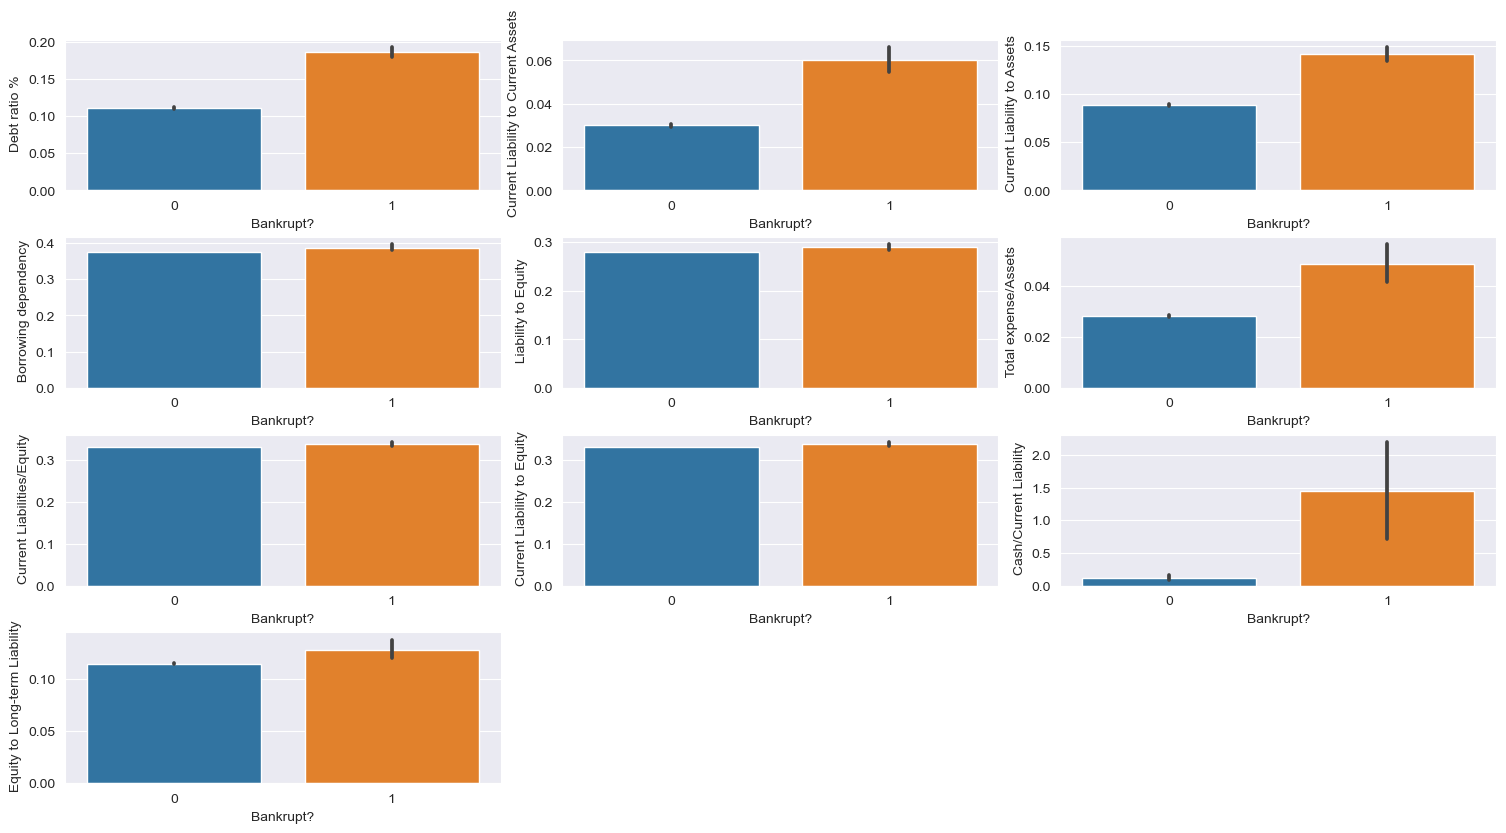

In [870]:
# Top 10 positively correlated features with "Bankrupt?"
x_value = positive_corr.columns.tolist()[-1]
y_value = positive_corr.columns.tolist()[:-1]

corrbargraph(x_value, y_value)

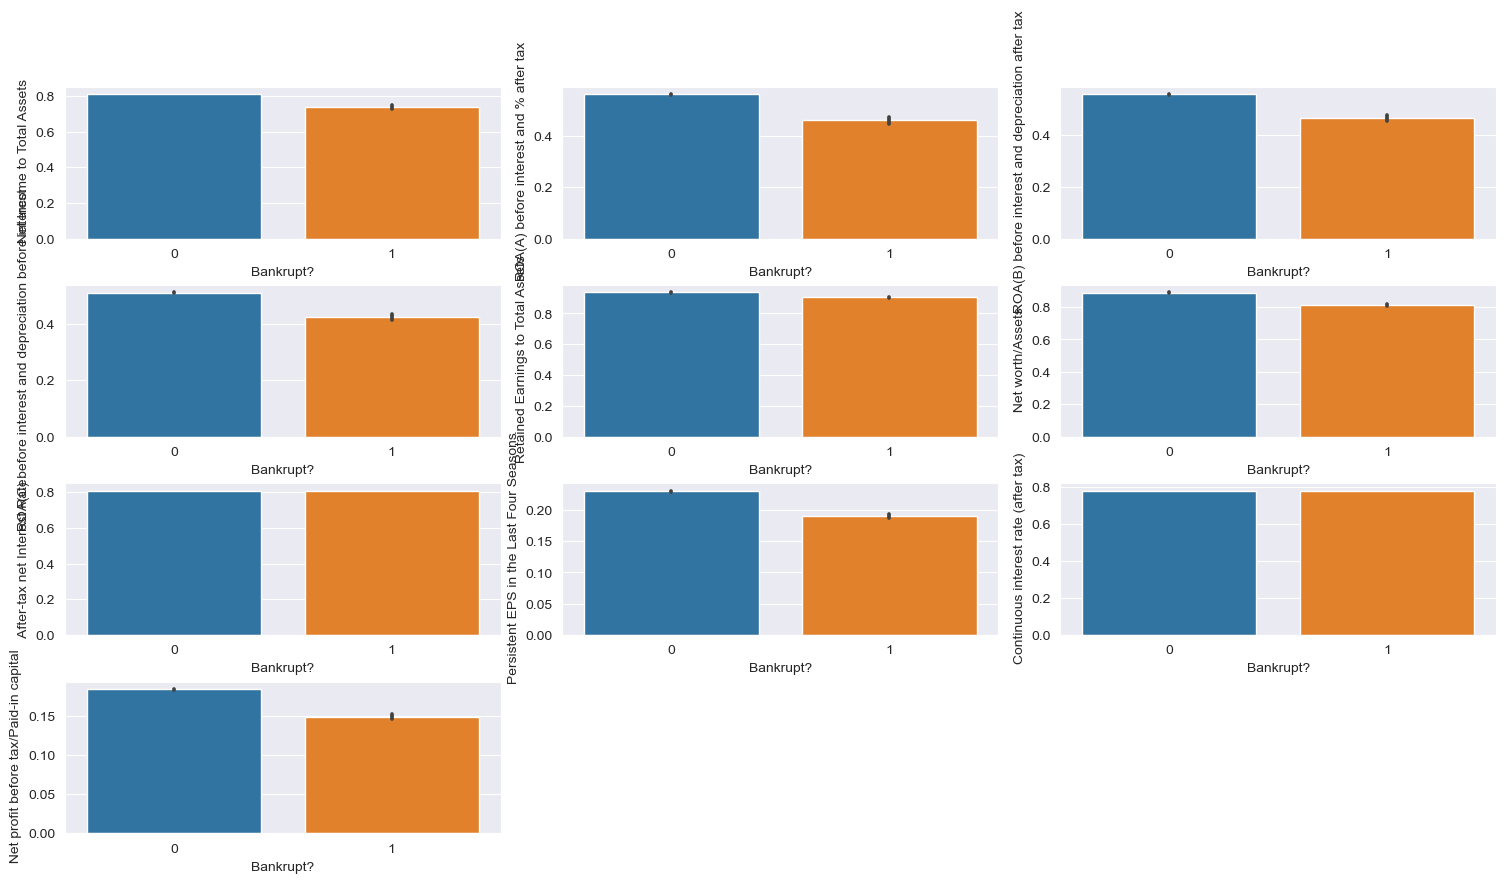

In [871]:
# Top 10 negatiavely correlated features with "Bankrupt?"
x_value = negative_corr.columns.tolist()[-1]
y_value = negative_corr.columns.tolist()[:-1]

corrbargraph(x_value, y_value)

In [872]:
# Let's get a clearer idea of which columns these are.
print("Top 10 positively correlated with Bankrupt\n", positive_corr.columns.tolist(), "\n")
print("Top 10 negatively correlated with Bankrupt\n", negative_corr.columns.tolist())

Top 10 positively correlated with Bankrupt
 [' Debt ratio %', ' Current Liability to Current Assets', ' Current Liability to Assets', ' Borrowing dependency', ' Liability to Equity', ' Total expense/Assets', ' Current Liabilities/Equity', ' Current Liability to Equity', ' Cash/Current Liability', ' Equity to Long-term Liability', 'Bankrupt?'] 

Top 10 negatively correlated with Bankrupt
 [' Net Income to Total Assets', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' ROA(C) before interest and depreciation before interest', ' Retained Earnings to Total Assets', ' Net worth/Assets', ' After-tax net Interest Rate', ' Persistent EPS in the Last Four Seasons', ' Continuous interest rate (after tax)', ' Net profit before tax/Paid-in capital', 'Bankrupt?']


##### EDA interpretation from bar plots above

*Positive correlations*: in bankrupt companies, their **Debt ratio %, Current Liability to Current Assets, and Current Liabilities to Assets, Total expense/Assets, Cash/Current Liability** are relatively strongly correlated to their bankruptcy state. As noted before, there are many similar variables in the df which we will deal with in the model training later with PCA transformation. But for now, interpreting this information, we can say that a company's debt ratio and ratio of their  liabilities to assets are indicative factors of their financial stability. This makes sense, as how much debt a company is in likely determines whether they can continue operating as normal without declaring bankruptcy. The ratios of liabilities to assets, whether they be current or not, also seems important as we can think of a company's assets as something they can mobilize to mitigate their liabilities, and the ratio of this can therefore be somewhat determinative of their ability to maintain financial stability and therefore avoid declaring bankruptcy. The company's expenses (spending) over what they own (assets) also seems determinative of whether they will be financially unstable, probably because it may indicate negative profits. (please note, I am not an Economics major and this is my interpretation plus personal research on bankruptcy terms).
<br><br>*Negative correlations*: in non bankrupt companies, their **Net Income to Total Assets, ROA(A) before interest and % after tax, ROA(B) before interest and depreciation after tax, ROA(C) before interest and depreciation before interest, Net worth/Assets, Persistent EPS in the Last Four Seasons, and Net profit before tax/Paid-in capital** are relatively strongly correlated to their non-bankruptcy state. Note: ROA means "Return on Total Assets", EPS means "earnings per share", and paid-in capital means the full amount of cash that shareholders have paid in exchange for stock. Accordingly, it makes sense that these variables, all having to do with the company's return on their assets, which are things they can deploy to make more profit, and their historical earnings per share and the ratio of their profits and real money capital they receive in return for their stocks are correlated with NOT being bankrupt. This perhaps also indicates the importance of real capital in non-bankruptcy, which is more flexible and immediately useable, along with the importance of assets, which are deployable in order to restructure/improve company profits and functions. Moreover, sometimes, earnings per share can indicate how confident the market is in that particular company, also indicating its potential to stay financially stable.

We can further visualize these correlations with a heat map:

<AxesSubplot:>

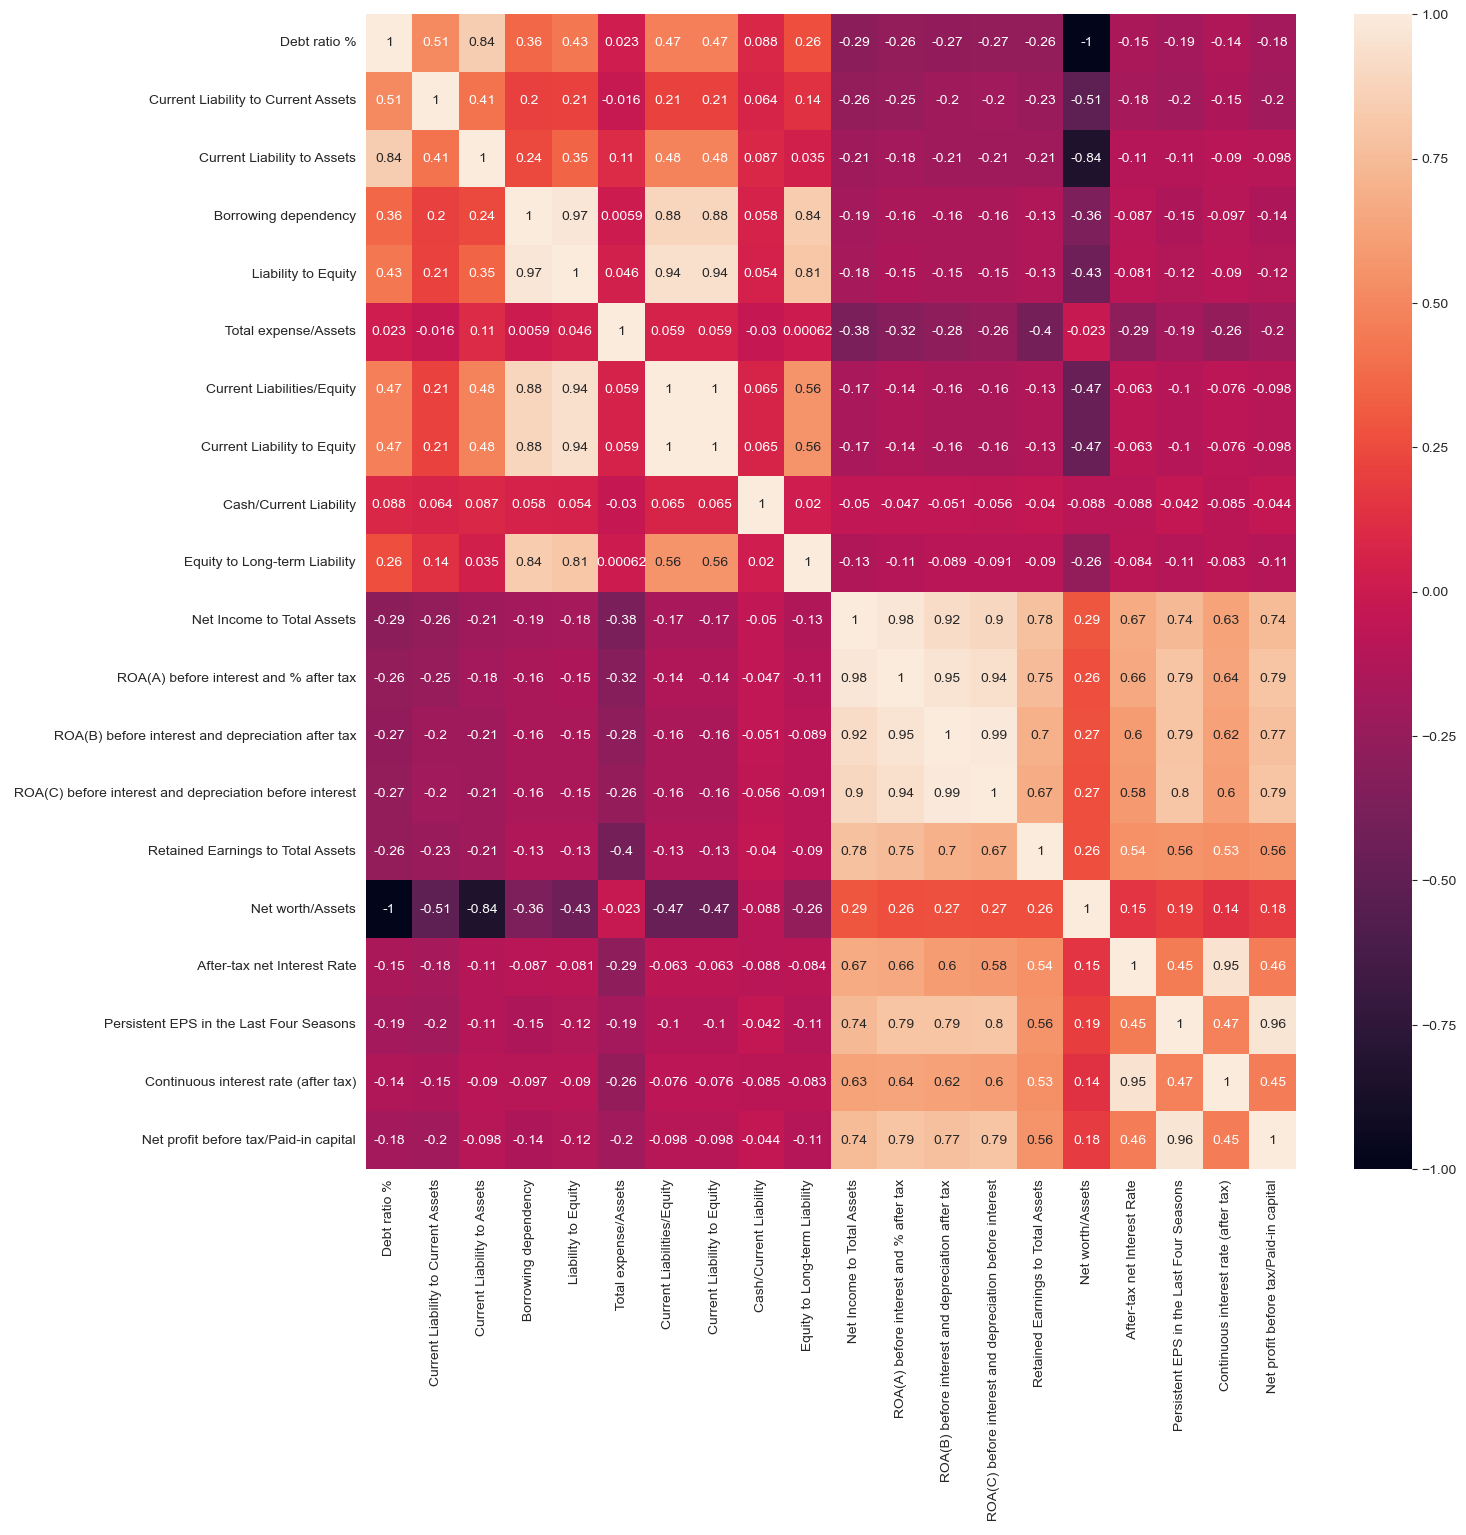

In [873]:
# Heat map of the correlation of top 10 positive and negative correlated attributes
relation = positive_corr.columns.tolist()[:-1] + negative_corr.columns.tolist()[:-1]
plt.figure(figsize=(15,15))
sns.heatmap(df[relation].corr(),annot=True)

The heatmap shows variable to variable correlations. The top left quadrant are the top 10 positively correlated variables to Bankruptcy plotted against each other, and the bottom right quadrant are the top 10 negatively correlated variables to Bankruptcy plotted against each other.

What this heatmap tells us is that there is generally moderately strong variable to variable correlations. This suggests that there may be a common underlying factor(s) driving the relationship between these variables and bankruptcy/non-bankruptcy.

For our ML training purposes, this can pose an issue. Strong correlation between feature variables, or multicollinearity, can lead to the reduction of model stability, difficulty in identifying important features, and high complexity, which can lead to overfitting. Seeing this, I'm even more convinced that PCA transformation will be the best way to deal with this dataset's feature variables.

### Data pre-processing: PCA transformation

As mentioned before, there are several reasons why PCA transformation seems like the best approach for this dataset. Recap: there are 94 features currently, and many of the variables are similar/related to one another, and furthermore, there may be indications of multicollinearity. Without the specific Economics knowledge to manually decide which features to keep (to reduce similarities), PCA transformation and feature selection remain as choices of how to deal with the dataset if we don't want to use every single feature.

We will therefore proceed with PCA transformation because PCA seems more appropriate for dealing with a dataset with many correlated features, where our goal is to reduce the dimensionality of the data.

When doing PCA, it is best practice to standardize the data. Remember, we have only performed data normalization. Therefore, we will have to use standard scaler from sklearn before we start the PCA transformation. Also, PCA is generally NOT appropriate for categorical variables. We will remove those from the PCA transformation data.

In [874]:
# Include all features of df besides id and the bankruptcy and the categorical variable
X = df.drop(columns=['Bankrupt?', ' Liability-Assets Flag']).copy(deep=True)

# Rescale the data to unit variance
scaler=StandardScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)

pca = PCA()
pca.fit(scaled_data)
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_,columns=['Variance explained'])
display(pca_var_explained.round(3))
print(f"Total variance explained in top 10 principal components: {pca_var_explained.loc[0:10].values.sum():.2%}")
print(f"Total variance explained in top 20 principal components: {pca_var_explained.loc[0:20].values.sum():.2%}")
print(f"Total variance explained in top 30 principal components: {pca_var_explained.loc[0:30].values.sum():.2%}")
print(f"Total variance explained in top 40 principal components: {pca_var_explained.loc[0:40].values.sum():.2%}")
print(f"Total variance explained in top 50 principal components: {pca_var_explained.loc[0:50].values.sum():.2%}")

,Variance explained
0,0.172
1,0.092
2,0.065
3,0.050
4,0.037
...,...
88,0.000
89,0.000
90,0.000
91,0.000


Total variance explained in top 10 principal components: 57.36%
Total variance explained in top 20 principal components: 71.06%
Total variance explained in top 30 principal components: 81.77%
Total variance explained in top 40 principal components: 90.47%
Total variance explained in top 50 principal components: 96.26%


##### PCA interpretation (NEEDS ADDITIONAL INTERPRETATION) 

Let's use top 30 principlal components because we do not want overfitting with too much variance explained.

Here, I will also recalculate the principal components on the entire set of X. This will not be subject to any 'lookahead' bias, as the principal components can always be recalculated once we observe the test X inputs (there is nothing based on the ground truth values in the principal components).

In [875]:
# Create a new df with the categorical variable added back with the top 30 PCA components

n_components = 30
pca = PCA(n_components=n_components)
pca.fit(scaled_data)
pca_df = pd.DataFrame(pca.transform(scaled_data), columns=[f"PC{i}" for i in range(1, n_components + 1)])
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,-8.954097,1.166261,-1.439913,0.867728,1.837958,0.117052,1.672802,1.185219,-0.558421,0.001424,-1.251448,-2.900970,-1.199496,-0.416431,-0.022627,-0.419951,-0.435105,-0.625442,-0.301630,-0.175120,-0.388626,-0.080414,0.582614,0.379606,-0.581432,0.102085,0.093786,0.213917,-0.065761,0.082997
1,-3.227184,-0.743827,-3.906518,1.102209,-0.198287,-0.335183,1.322732,-1.153676,-0.544676,1.996651,-0.246314,-0.024958,-0.610048,-0.313392,0.035680,-0.578583,1.394797,0.872554,-0.414026,2.741549,-2.647771,-0.706657,0.352399,9.332914,8.404874,-3.361690,-0.093966,1.366645,1.645740,5.794690
2,-6.384623,-1.384824,1.034893,0.694307,-0.619941,3.231027,2.531710,-2.064904,0.934629,2.443442,-2.942469,3.877426,0.186998,-1.933320,-0.174690,-0.162992,0.411686,-4.348370,-2.695406,0.797125,2.392161,4.275761,-0.356138,-1.213410,0.663809,-1.203689,0.645999,0.276884,0.455654,0.787548
3,-7.457901,-0.719565,-2.858354,-0.237452,1.050185,0.911367,-0.521569,1.077512,-0.952735,0.187565,-0.787407,0.053682,0.543784,-0.658955,0.110612,-1.408941,0.879295,0.934552,0.444062,-0.080417,-0.153906,-0.611666,-0.375397,-0.037099,0.068657,0.214818,-0.053515,0.003846,-1.013706,-0.144389
4,-2.795927,1.075959,-0.890623,-1.500379,0.534030,-0.650514,-0.845976,1.169757,-0.683705,-0.357742,-1.341675,-1.215774,1.597770,0.064607,-0.819737,-0.327929,0.277138,0.304564,-0.145820,1.414212,0.006058,-0.343221,0.383488,0.652581,-0.292819,0.128993,0.044650,0.653810,-0.058751,-0.840554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6715,-2.719043,0.097179,-2.122379,-0.425575,0.232569,-0.131045,-0.407176,-1.057870,0.271331,-0.997123,0.430076,0.238690,-0.066139,0.264831,0.391276,0.303941,0.048897,-0.170682,-0.276204,1.909388,-0.131739,0.888827,-1.261917,1.017197,-0.538510,-0.117730,-0.229644,-0.062621,0.171127,-1.762855
6716,-1.364708,-0.702729,-0.104906,0.093115,-0.071487,-0.784507,0.346526,-0.774754,0.528358,-0.843036,0.540020,1.059432,0.230867,-0.028996,0.206508,-0.273720,-0.129367,0.085371,0.277162,0.136761,-0.037523,-0.125950,-0.183045,-0.257736,0.173215,0.064015,-0.125612,-0.155777,-0.091319,-0.106552
6717,-1.575394,0.063331,-0.578195,-1.209056,-0.673714,-0.364778,-1.121588,-0.504323,0.856152,-1.375740,-0.189174,0.421644,0.146954,0.872446,-0.741911,1.217610,-0.797574,-0.139411,0.248923,-0.054683,-0.388663,1.477726,0.714032,0.718164,-0.753337,-0.128801,0.075327,0.609440,0.711627,-0.188836
6718,2.109169,-3.409916,1.412348,0.165795,-1.676328,2.510296,-1.567253,0.590418,-0.207956,-0.381539,0.709730,-1.138702,-2.623941,-0.484427,0.167222,0.525237,0.622291,-0.444430,-0.840827,0.102646,0.015870,0.308947,-0.326427,-0.213028,0.393890,-0.248988,0.112188,-0.278262,-0.097876,-0.440395


In [876]:
pca_df['Liability-Assets Flag'] = df[' Liability-Assets Flag'].copy(deep=True) # removed space from pca_df variable name

In [877]:
pca_df # let's check to make sure the column was added

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,Liability-Assets Flag
0,-8.954097,1.166261,-1.439913,0.867728,1.837958,0.117052,1.672802,1.185219,-0.558421,0.001424,-1.251448,-2.900970,-1.199496,-0.416431,-0.022627,-0.419951,-0.435105,-0.625442,-0.301630,-0.175120,-0.388626,-0.080414,0.582614,0.379606,-0.581432,0.102085,0.093786,0.213917,-0.065761,0.082997,0.0
1,-3.227184,-0.743827,-3.906518,1.102209,-0.198287,-0.335183,1.322732,-1.153676,-0.544676,1.996651,-0.246314,-0.024958,-0.610048,-0.313392,0.035680,-0.578583,1.394797,0.872554,-0.414026,2.741549,-2.647771,-0.706657,0.352399,9.332914,8.404874,-3.361690,-0.093966,1.366645,1.645740,5.794690,0.0
2,-6.384623,-1.384824,1.034893,0.694307,-0.619941,3.231027,2.531710,-2.064904,0.934629,2.443442,-2.942469,3.877426,0.186998,-1.933320,-0.174690,-0.162992,0.411686,-4.348370,-2.695406,0.797125,2.392161,4.275761,-0.356138,-1.213410,0.663809,-1.203689,0.645999,0.276884,0.455654,0.787548,0.0
3,-7.457901,-0.719565,-2.858354,-0.237452,1.050185,0.911367,-0.521569,1.077512,-0.952735,0.187565,-0.787407,0.053682,0.543784,-0.658955,0.110612,-1.408941,0.879295,0.934552,0.444062,-0.080417,-0.153906,-0.611666,-0.375397,-0.037099,0.068657,0.214818,-0.053515,0.003846,-1.013706,-0.144389,0.0
4,-2.795927,1.075959,-0.890623,-1.500379,0.534030,-0.650514,-0.845976,1.169757,-0.683705,-0.357742,-1.341675,-1.215774,1.597770,0.064607,-0.819737,-0.327929,0.277138,0.304564,-0.145820,1.414212,0.006058,-0.343221,0.383488,0.652581,-0.292819,0.128993,0.044650,0.653810,-0.058751,-0.840554,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6715,-2.719043,0.097179,-2.122379,-0.425575,0.232569,-0.131045,-0.407176,-1.057870,0.271331,-0.997123,0.430076,0.238690,-0.066139,0.264831,0.391276,0.303941,0.048897,-0.170682,-0.276204,1.909388,-0.131739,0.888827,-1.261917,1.017197,-0.538510,-0.117730,-0.229644,-0.062621,0.171127,-1.762855,0.0
6716,-1.364708,-0.702729,-0.104906,0.093115,-0.071487,-0.784507,0.346526,-0.774754,0.528358,-0.843036,0.540020,1.059432,0.230867,-0.028996,0.206508,-0.273720,-0.129367,0.085371,0.277162,0.136761,-0.037523,-0.125950,-0.183045,-0.257736,0.173215,0.064015,-0.125612,-0.155777,-0.091319,-0.106552,0.0
6717,-1.575394,0.063331,-0.578195,-1.209056,-0.673714,-0.364778,-1.121588,-0.504323,0.856152,-1.375740,-0.189174,0.421644,0.146954,0.872446,-0.741911,1.217610,-0.797574,-0.139411,0.248923,-0.054683,-0.388663,1.477726,0.714032,0.718164,-0.753337,-0.128801,0.075327,0.609440,0.711627,-0.188836,0.0
6718,2.109169,-3.409916,1.412348,0.165795,-1.676328,2.510296,-1.567253,0.590418,-0.207956,-0.381539,0.709730,-1.138702,-2.623941,-0.484427,0.167222,0.525237,0.622291,-0.444430,-0.840827,0.102646,0.015870,0.308947,-0.326427,-0.213028,0.393890,-0.248988,0.112188,-0.278262,-0.097876,-0.440395,0.0


## Random Under Sampling --> may change to stratified. need to rewrite description
Before we begin tuning parameters for our models and training them, we will have to deal with the dataset imbalance. I will choose to do stratified random sampling instead of simple random sampling such that the variables match the population data. 

Remember, our goal is to balance our imbalanced dataset, which only has 210 instances in the minority class. We can choose to either over sample or under/down sample. It is generally better to downsample, which is where we sample the same number of the majority class as the minority class, because in this case we want to avoid the models from learning to classify most things into the majority class.

However, we then have to deal with *how* to select from our majority class. We can randomly choose the same number of samples from the majority class, but that may not be the best idea as that sample's features may not be representative of the population (original df). Therefore, I will choose to do stratified random sampling.

In [894]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pca_df, df['Bankrupt?'])

In [895]:
X_resampled.shape # checking size. should be 2*210 (number of minority class target) = 420

(420, 31)

In [899]:
y_resampled.shape

(420,)

In [898]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
# should I use the stratify=y parameter?

## Models: Parameter tuning

For our chosen models (RF classifier, logistic regression, SVM), we will need to figure out the optimal parameters to train the models on. We will do this using sklearn function GridSearchCV

# SAMPLING, TUNING